## 工作流程
- 資料載入與前處理（學生為單位、週為時間粒度）
- 建立 Seq2Seq LSTM 與 Seq2Seq VAE 模型
- 訓練與評估（MSE、Best-of-N、Coverage、Diversity）
- 可視化比較單一路徑與多樣生成能力


## 資料下載與檔案結構
- 從 Kaggle 下載 [Open University Learning Analytics Dataset (OULAD)](https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad?resource=download)。
- 將 `studentInfo.csv`, `studentVle.csv`, `studentAssessment.csv` 放在 `data/oulad/` 資料夾下（若不同請修改 `DATA_DIR`）。
- 若筆記第一次執行，建議先跑一次資料前處理區塊以建立快取。


In [9]:
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
sns.set(style='whitegrid')


In [10]:
DATA_DIR = Path('data/oulad')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PAST_STEPS = 4
FUTURE_STEPS = 2
BATCH_SIZE = 128
LR = 1e-3
EPOCHS_LSTM = 20
EPOCHS_VAE = 30
HIDDEN_DIM = 64
LATENT_DIM = 16
BETA = 0.1
MAX_STUDENTS = None  # 設定為整數可減少訓練規模加速除錯
NUM_WORKERS = 0
SEED = 42

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {DEVICE}')


使用裝置: cuda


In [11]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

def check_required_files(data_dir: Path) -> None:
    required = ['studentInfo.csv', 'studentVle.csv', 'studentAssessment.csv']
    # Check if files exist directly in data_dir or in a subdirectory
    found_files = []
    for root, dirs, files in os.walk(data_dir):
        for f in required:
            if f in files:
                found_files.append(f)
    missing = [f for f in required if f not in found_files]

    if missing:
        msg = '\n'.join(missing)
        raise FileNotFoundError(
            f'找不到下列必要檔案，請確認路徑 `{data_dir}`:\n{msg}'
        )
    else:
        print("所有必要檔案都已找到。")


check_required_files(DATA_DIR)

所有必要檔案都已找到。


In [12]:
!pip install opendatasets

import opendatasets as od

# Set this to the Kaggle dataset URL
dataset_url = 'https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad'

od.download(dataset_url, DATA_DIR)

Skipping, found downloaded files in "data/oulad/student-demographics-online-education-dataoulad" (use force=True to force download)


In [13]:
def load_oulad(data_dir: Path):
    # Assuming opendatasets creates a subdirectory with the dataset name
    dataset_subdir = next(data_dir.iterdir())
    student_info = pd.read_csv(dataset_subdir / 'studentInfo.csv')
    student_vle = pd.read_csv(dataset_subdir / 'studentVle.csv')
    student_assessment = pd.read_csv(dataset_subdir / 'studentAssessment.csv')
    return student_info, student_vle, student_assessment

student_info, student_vle, student_assessment = load_oulad(DATA_DIR)
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [14]:
def build_weekly_clicks(vle_df: pd.DataFrame) -> pd.DataFrame:
    df = vle_df.copy()
    df = df[df['date'].notna()]
    df['week'] = (df['date'].clip(lower=0) // 7).astype(int)
    agg = (
        df.groupby(['code_module', 'code_presentation', 'id_student', 'week'])['sum_click']
          .sum()
          .reset_index()
    )
    agg = agg.rename(columns={'sum_click': 'clicks'})
    return agg

def build_weekly_submissions(assessment_df: pd.DataFrame, student_info_df: pd.DataFrame) -> pd.DataFrame:
    df = assessment_df.copy()
    df = df[df['date_submitted'].notna()]
    df = df[df['date_submitted'] >= 0]
    df['week'] = (df['date_submitted'] // 7).astype(int)
    # Merge with student_info to get code_module and code_presentation
    df = df.merge(student_info_df[['id_student', 'code_module', 'code_presentation']].drop_duplicates(), on='id_student', how='left')
    agg = (
        df.groupby(['code_module', 'code_presentation', 'id_student', 'week'])
          .agg(submit_cnt=('id_assessment', 'count'), score_sum=('score', 'sum'))
          .reset_index()
    )
    return agg

weekly_clicks = build_weekly_clicks(student_vle)
weekly_submissions = build_weekly_submissions(student_assessment, student_info)

max_week_clicks = int(weekly_clicks['week'].max()) if not weekly_clicks.empty else 0
max_week_subs = int(weekly_submissions['week'].max()) if not weekly_submissions.empty else 0
GLOBAL_MAX_WEEK = int(max(max_week_clicks, max_week_subs))
print(f'週數範圍 0 ~ {GLOBAL_MAX_WEEK}')
weekly_clicks.head()

週數範圍 0 ~ 86


,code_module,code_presentation,id_student,week,clicks
0,AAA,2013J,11391,0,281
1,AAA,2013J,11391,1,20
2,AAA,2013J,11391,2,100
3,AAA,2013J,11391,4,26
4,AAA,2013J,11391,5,60


In [15]:
def prepare_student_weekly_frames(
    student_info: pd.DataFrame,
    weekly_clicks: pd.DataFrame,
    weekly_submissions: pd.DataFrame,
    max_students: int | None = None
) -> dict:
    students = student_info[['code_module', 'code_presentation', 'id_student']].drop_duplicates()
    if max_students is not None:
        students = students.sample(n=min(max_students, len(students)), random_state=SEED)
    click_group = weekly_clicks.groupby(['code_module', 'code_presentation', 'id_student'])
    submit_group = weekly_submissions.groupby(['code_module', 'code_presentation', 'id_student'])
    student_frames: dict[tuple, pd.DataFrame] = {}
    for row in students.itertuples(index=False):
        key = (row.code_module, row.code_presentation, row.id_student)
        click_df = click_group.get_group(key) if key in click_group.groups else None
        submit_df = submit_group.get_group(key) if key in submit_group.groups else None
        if click_df is None and submit_df is None:
            continue
        weeks = np.arange(0, GLOBAL_MAX_WEEK + 1)
        base = pd.DataFrame({'week': weeks})
        if click_df is not None:
            base = base.merge(click_df[['week', 'clicks']], on='week', how='left')
        else:
            base['clicks'] = 0
        if submit_df is not None:
            base = base.merge(submit_df[['week', 'submit_cnt', 'score_sum']], on='week', how='left')
        else:
            base['submit_cnt'] = np.nan
            base['score_sum'] = np.nan
        base[['clicks', 'submit_cnt', 'score_sum']] = base[['clicks', 'submit_cnt', 'score_sum']].fillna(0)
        base['has_submit'] = (base['submit_cnt'] > 0).astype(float)
        base['cum_submit'] = base['submit_cnt'].cumsum()
        base['cum_score'] = base['score_sum'].cumsum()
        base['avg_score_sofar'] = 0.0
        mask = base['cum_submit'] > 0
        base.loc[mask, 'avg_score_sofar'] = base.loc[mask, 'cum_score'] / base.loc[mask, 'cum_submit']
        base['clicks_diff1'] = base['clicks'].diff().fillna(0)
        base['student_key'] = '_'.join(map(str, key))
        base['code_module'] = row.code_module
        base['code_presentation'] = row.code_presentation
        base['id_student'] = row.id_student
        student_frames[key] = base
    return student_frames

student_weekly = prepare_student_weekly_frames(
    student_info,
    weekly_clicks,
    weekly_submissions,
    max_students=MAX_STUDENTS
)
len(student_weekly)


29630

In [16]:
FEATURE_COLUMNS = ['clicks', 'clicks_diff1', 'submit_cnt', 'has_submit', 'avg_score_sofar']

def build_sequences(
    student_frames: dict,
    past_steps: int,
    future_steps: int,
    feature_columns: list[str]
) -> dict[str, list[dict]]:
    sequences_by_student: dict[str, list[dict]] = {}
    span = past_steps + future_steps
    for key, df in student_frames.items():
        df = df.sort_values('week').reset_index(drop=True)
        features = df[feature_columns].to_numpy(dtype=np.float32)
        clicks_future = df['clicks'].to_numpy(dtype=np.float32)
        seqs: list[dict] = []
        total_steps = len(df)
        for start in range(0, total_steps - span + 1):
            past_slice = features[start:start + past_steps]
            future_slice = clicks_future[start + past_steps:start + span]
            if np.allclose(past_slice, 0) and np.allclose(future_slice, 0):
                continue
            seqs.append({
                'inputs': past_slice,
                'target': future_slice,
                'student_key': df.loc[0, 'student_key'],
                'start_week': int(df.loc[start, 'week'])
            })
        if seqs:
            sequences_by_student[df.loc[0, 'student_key']] = seqs
    return sequences_by_student

student_sequences = build_sequences(
    student_weekly,
    PAST_STEPS,
    FUTURE_STEPS,
    FEATURE_COLUMNS
)
len(student_sequences)


29630

In [17]:
def flatten_sequences(selected_keys: list[str], sequences_by_student: dict[str, list[dict]]):
    flattened: list[dict] = []
    for key in selected_keys:
        flattened.extend(sequences_by_student[key])
    return flattened

all_student_keys = list(student_sequences.keys())
train_keys, temp_keys = train_test_split(all_student_keys, test_size=0.3, random_state=SEED)
valid_keys, test_keys = train_test_split(temp_keys, test_size=0.5, random_state=SEED)

train_sequences = flatten_sequences(train_keys, student_sequences)
valid_sequences = flatten_sequences(valid_keys, student_sequences)
test_sequences = flatten_sequences(test_keys, student_sequences)

print(f'Train/Valid/Test 範例數: {len(train_sequences)}, {len(valid_sequences)}, {len(test_sequences)}')

train_array = np.stack([seq['inputs'] for seq in train_sequences])
feature_mean = train_array.reshape(-1, train_array.shape[-1]).mean(axis=0)
feature_std = train_array.reshape(-1, train_array.shape[-1]).std(axis=0)
feature_std[feature_std == 0] = 1.0
feature_stats = {'mean': feature_mean, 'std': feature_std, 'columns': FEATURE_COLUMNS}
feature_stats


Train/Valid/Test 範例數: 1540624, 325785, 330362


{'mean': array([15.856688  , -1.4119792 ,  0.09044566,  0.07705644, 71.43496   ],
       dtype=float32),
 'std': array([55.40259   , 55.718266  ,  0.34524953,  0.25999227, 19.385342  ],
       dtype=float32),
 'columns': ['clicks',
  'clicks_diff1',
  'submit_cnt',
  'has_submit',
  'avg_score_sofar']}

In [18]:
class SequenceDataset(Dataset):
    def __init__(self, sequences: list[dict], feature_stats: dict):
        self.sequences = sequences
        self.feature_mean = feature_stats['mean'].astype(np.float32)
        self.feature_std = feature_stats['std'].astype(np.float32)
        self.feature_columns = feature_stats['columns']

    def __len__(self) -> int:
        return len(self.sequences)

    def normalize_features(self, array: np.ndarray) -> np.ndarray:
        return (array - self.feature_mean) / self.feature_std

    def __getitem__(self, idx: int):
        seq = self.sequences[idx]
        inputs = seq['inputs'].astype(np.float32)
        inputs = self.normalize_features(inputs)
        target = seq['target'].astype(np.float32)
        return (
            torch.from_numpy(inputs),
            torch.from_numpy(target),
            seq['student_key'],
            seq['start_week']
        )

train_dataset = SequenceDataset(train_sequences, feature_stats)
valid_dataset = SequenceDataset(valid_sequences, feature_stats)
test_dataset = SequenceDataset(test_sequences, feature_stats)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS)

len(train_dataset), len(valid_dataset), len(test_dataset)


(1540624, 325785, 330362)

In [19]:
CLICK_IDX = FEATURE_COLUMNS.index('clicks')
feature_mean_tensor = torch.tensor(feature_stats['mean'], dtype=torch.float32, device=DEVICE)
feature_std_tensor = torch.tensor(feature_stats['std'], dtype=torch.float32, device=DEVICE)

def last_click_from_inputs(batch_inputs: torch.Tensor) -> torch.Tensor:
    normalized = batch_inputs[:, -1, CLICK_IDX]
    return normalized * feature_std_tensor[CLICK_IDX] + feature_mean_tensor[CLICK_IDX]

def denormalize_click_sequence(normalized_clicks: np.ndarray) -> np.ndarray:
    return normalized_clicks * feature_stats['std'][CLICK_IDX] + feature_stats['mean'][CLICK_IDX]

example_inputs, example_target, example_student, example_week = train_dataset[0]
history_clicks = denormalize_click_sequence(example_inputs[:, CLICK_IDX].numpy())
print(f'學生 {example_student} 從週 {example_week} 開始的歷史 clicks: {history_clicks}')
print(f'目標未來 clicks: {example_target.numpy()}')


學生 DDD_2013J_527574 從週 0 開始的歷史 clicks: [191.   3.  99.  54.]
目標未來 clicks: [42. 38.]


In [20]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, future_steps: int):
        super().__init__()
        self.future_steps = future_steps
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(1, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(
        self,
        src: torch.Tensor,
        prev_clicks: torch.Tensor,
        targets: torch.Tensor | None = None,
        teacher_forcing: float = 0.5
    ) -> torch.Tensor:
        _, (hidden, cell) = self.encoder(src)
        decoder_input = prev_clicks.unsqueeze(-1).unsqueeze(-1)
        outputs = []
        for step in range(self.future_steps):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.output_layer(decoder_output.squeeze(1))
            outputs.append(pred)
            if targets is not None and random.random() < teacher_forcing:
                next_input = targets[:, step]
            else:
                next_input = pred.squeeze(1)
            decoder_input = next_input.unsqueeze(-1).unsqueeze(-1)
        outputs = torch.stack(outputs, dim=1).squeeze(-1)
        return outputs

mse_loss = nn.MSELoss()

lstm_model = Seq2SeqLSTM(
    input_dim=len(FEATURE_COLUMNS),
    hidden_dim=HIDDEN_DIM,
    future_steps=FUTURE_STEPS
).to(DEVICE)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)

def run_lstm_epoch(
    model: Seq2SeqLSTM,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer | None = None,
    teacher_forcing: float = 0.5
) -> float:
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    count = 0
    for batch_inputs, batch_targets, _, _ in dataloader:
        batch_inputs = batch_inputs.to(DEVICE)
        batch_targets = batch_targets.to(DEVICE)
        prev_clicks = last_click_from_inputs(batch_inputs)
        if is_train:
            optimizer.zero_grad()
        outputs = model(
            batch_inputs,
            prev_clicks,
            targets=batch_targets if is_train else None,
            teacher_forcing=teacher_forcing if is_train else 0.0
        )
        loss = mse_loss(outputs, batch_targets)
        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        total_loss += loss.item() * batch_inputs.size(0)
        count += batch_inputs.size(0)
    return total_loss / max(count, 1)

def train_lstm_model(
    model: Seq2SeqLSTM,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    teacher_forcing: float = 0.5
):
    history = {'train': [], 'valid': []}
    best_val = float('inf')
    best_state = None
    for epoch in range(1, epochs + 1):
        train_loss = run_lstm_epoch(model, train_loader, optimizer, teacher_forcing=teacher_forcing)
        valid_loss = run_lstm_epoch(model, valid_loader, optimizer=None, teacher_forcing=0.0)
        history['train'].append(train_loss)
        history['valid'].append(valid_loss)
        if valid_loss < best_val:
            best_val = valid_loss
            best_state = {k: v.clone().detach() for k, v in model.state_dict().items()}
        print(f'[LSTM][Epoch {epoch:02d}] train={train_loss:.4f} valid={valid_loss:.4f}')
    if best_state is not None:
        model.load_state_dict(best_state)
    return history


[LSTM][Epoch 01] train=1824.4136 valid=1764.8098
[LSTM][Epoch 02] train=1691.1775 valid=1739.4867
[LSTM][Epoch 03] train=1677.7703 valid=1730.2305
[LSTM][Epoch 04] train=1672.5164 valid=1731.5125
[LSTM][Epoch 05] train=1667.0556 valid=1723.5764
[LSTM][Epoch 06] train=1665.9670 valid=1723.6184
[LSTM][Epoch 07] train=1667.4228 valid=1727.0027
[LSTM][Epoch 08] train=1664.5199 valid=1726.2656
[LSTM][Epoch 09] train=1663.0459 valid=1723.0813
[LSTM][Epoch 10] train=1665.0062 valid=1730.8254
[LSTM][Epoch 11] train=1660.0904 valid=1727.6941
[LSTM][Epoch 12] train=1659.9272 valid=1724.7534
[LSTM][Epoch 13] train=1655.5833 valid=1725.5026
[LSTM][Epoch 14] train=1657.0091 valid=1725.6976
[LSTM][Epoch 15] train=1655.8942 valid=1734.6674
[LSTM][Epoch 16] train=1653.3884 valid=1723.2038
[LSTM][Epoch 17] train=1651.5973 valid=1717.1976
[LSTM][Epoch 18] train=1649.0543 valid=1722.8112
[LSTM][Epoch 19] train=1648.9159 valid=1717.4365
[LSTM][Epoch 20] train=1648.2681 valid=1725.2990


/tmp/ipython-input-632101446.py:17: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-632101446.py:17: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-632101446.py:17: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-632101446.py:17: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

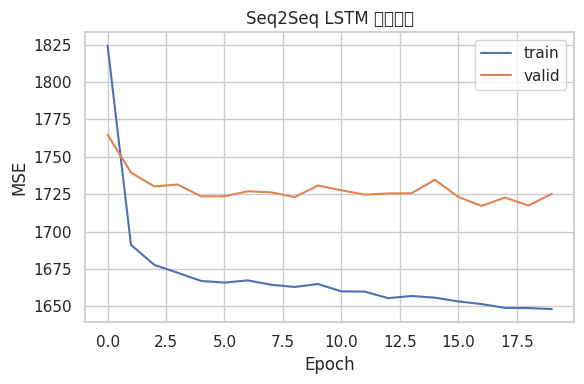

In [21]:
lstm_history = train_lstm_model(
    lstm_model,
    train_loader,
    valid_loader,
    lstm_optimizer,
    epochs=EPOCHS_LSTM,
    teacher_forcing=0.5
)

plt.figure(figsize=(6, 4))
plt.plot(lstm_history['train'], label='train')
plt.plot(lstm_history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Seq2Seq LSTM 訓練曲線')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
class Seq2SeqVAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int, future_steps: int):
        super().__init__()
        self.future_steps = future_steps
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(1, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def encode(self, src: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        _, (hidden, _) = self.encoder(src)
        hidden = hidden[-1]
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(
        self,
        z: torch.Tensor,
        initial_clicks: torch.Tensor,
        teacher_targets: torch.Tensor | None = None,
        teacher_forcing: float = 0.0
    ) -> torch.Tensor:
        hidden = torch.tanh(self.latent_to_hidden(z)).unsqueeze(0)
        cell = torch.zeros_like(hidden)
        decoder_input = initial_clicks.unsqueeze(-1).unsqueeze(-1)
        outputs = []
        for step in range(self.future_steps):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.output_layer(decoder_output.squeeze(1))
            outputs.append(pred)
            if teacher_targets is not None and random.random() < teacher_forcing:
                next_input = teacher_targets[:, step]
            else:
                next_input = pred.squeeze(1)
            decoder_input = next_input.unsqueeze(-1).unsqueeze(-1)
        outputs = torch.stack(outputs, dim=1).squeeze(-1)
        return outputs

    def forward(
        self,
        src: torch.Tensor,
        initial_clicks: torch.Tensor,
        targets: torch.Tensor | None = None,
        teacher_forcing: float = 0.0,
        sampling: bool = True
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(src)
        z = self.reparameterize(mu, logvar) if sampling else mu
        outputs = self.decode(z, initial_clicks, teacher_targets=targets, teacher_forcing=teacher_forcing)
        return outputs, mu, logvar

    def sample(self, src: torch.Tensor, initial_clicks: torch.Tensor, n_samples: int = 20) -> torch.Tensor:
        mu, logvar = self.encode(src)
        samples = []
        for _ in range(n_samples):
            z = self.reparameterize(mu, logvar)
            preds = self.decode(z, initial_clicks, teacher_targets=None, teacher_forcing=0.0)
            samples.append(preds.unsqueeze(0))
        return torch.cat(samples, dim=0)

vae_model = Seq2SeqVAE(
    input_dim=len(FEATURE_COLUMNS),
    hidden_dim=HIDDEN_DIM,
    latent_dim=LATENT_DIM,
    future_steps=FUTURE_STEPS
).to(DEVICE)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=LR)

def kld_loss(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def run_vae_epoch(
    model: Seq2SeqVAE,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer | None = None,
    beta: float = BETA
):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    recon_loss_total = 0.0
    kld_loss_total = 0.0
    count = 0
    for batch_inputs, batch_targets, _, _ in dataloader:
        batch_inputs = batch_inputs.to(DEVICE)
        batch_targets = batch_targets.to(DEVICE)
        initial_clicks = last_click_from_inputs(batch_inputs)
        if is_train:
            optimizer.zero_grad()
        outputs, mu, logvar = model(
            batch_inputs,
            initial_clicks,
            targets=batch_targets if is_train else None,
            teacher_forcing=0.3 if is_train else 0.0,
            sampling=True
        )
        recon = mse_loss(outputs, batch_targets)
        kld = kld_loss(mu, logvar)
        loss = recon + beta * kld
        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        total_loss += loss.item() * batch_inputs.size(0)
        recon_loss_total += recon.item() * batch_inputs.size(0)
        kld_loss_total += kld.item() * batch_inputs.size(0)
        count += batch_inputs.size(0)
    avg_loss = total_loss / max(count, 1)
    avg_recon = recon_loss_total / max(count, 1)
    avg_kld = kld_loss_total / max(count, 1)
    return avg_loss, avg_recon, avg_kld

def train_vae_model(
    model: Seq2SeqVAE,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    beta: float = BETA
):
    history = {
        'train': [],
        'valid': [],
        'train_recon': [],
        'valid_recon': [],
        'train_kld': [],
        'valid_kld': []
    }
    best_val = float('inf')
    best_state = None
    for epoch in range(1, epochs + 1):
        train_loss, train_recon, train_kld = run_vae_epoch(model, train_loader, optimizer, beta=beta)
        valid_loss, valid_recon, valid_kld = run_vae_epoch(model, valid_loader, optimizer=None, beta=beta)
        history['train'].append(train_loss)
        history['valid'].append(valid_loss)
        history['train_recon'].append(train_recon)
        history['valid_recon'].append(valid_recon)
        history['train_kld'].append(train_kld)
        history['valid_kld'].append(valid_kld)
        if valid_loss < best_val:
            best_val = valid_loss
            best_state = {k: v.clone().detach() for k, v in model.state_dict().items()}
        print(
            f'[VAE][Epoch {epoch:02d}] '
            f'train={train_loss:.4f} (recon {train_recon:.4f} / kld {train_kld:.4f}) '
            f'valid={valid_loss:.4f} (recon {valid_recon:.4f} / kld {valid_kld:.4f})'
        )
    if best_state is not None:
        model.load_state_dict(best_state)
    return history


[VAE][Epoch 01] train=1874.8394 (recon 1874.6615 / kld 1.7788) valid=1783.1860 (recon 1782.9958 / kld 1.9015)
[VAE][Epoch 02] train=1724.5629 (recon 1724.3408 / kld 2.2215) valid=1764.2184 (recon 1763.9893 / kld 2.2907)
[VAE][Epoch 03] train=1709.5822 (recon 1709.3388 / kld 2.4344) valid=1756.2599 (recon 1755.9906 / kld 2.6931)
[VAE][Epoch 04] train=1708.5652 (recon 1708.3075 / kld 2.5771) valid=1743.8281 (recon 1743.5654 / kld 2.6266)
[VAE][Epoch 05] train=1700.7725 (recon 1700.5150 / kld 2.5753) valid=1737.2434 (recon 1736.9694 / kld 2.7396)
[VAE][Epoch 06] train=1698.2461 (recon 1697.9754 / kld 2.7070) valid=1745.2836 (recon 1744.9927 / kld 2.9097)
[VAE][Epoch 07] train=1693.3413 (recon 1693.0611 / kld 2.8023) valid=1743.6300 (recon 1743.3456 / kld 2.8439)
[VAE][Epoch 08] train=1692.2137 (recon 1691.9458 / kld 2.6791) valid=1739.4584 (recon 1739.1945 / kld 2.6391)
[VAE][Epoch 09] train=1692.0913 (recon 1691.8302 / kld 2.6112) valid=1749.2419 (recon 1748.9820 / kld 2.5983)
[VAE][Epoc

/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:17: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missi

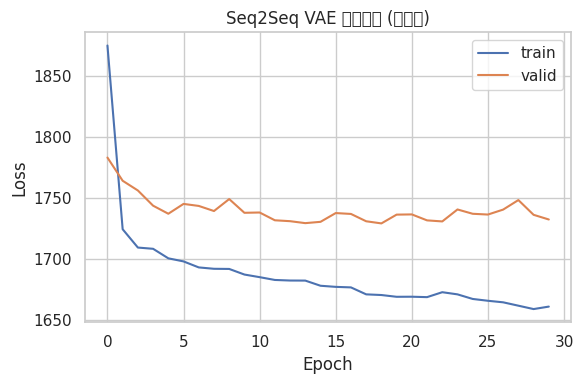

/tmp/ipython-input-1664020048.py:27: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:27: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:27: UserWarning: Glyph 35492 (\N{CJK UNIFIED IDEOGRAPH-8AA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:27: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

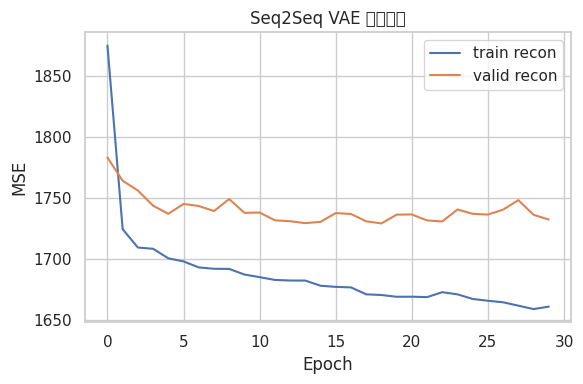

/tmp/ipython-input-1664020048.py:37: UserWarning: Glyph 30435 (\N{CJK UNIFIED IDEOGRAPH-76E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1664020048.py:37: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30435 (\N{CJK UNIFIED IDEOGRAPH-76E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


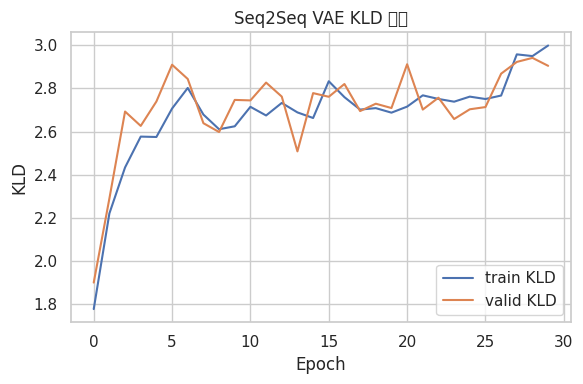

In [23]:
vae_history = train_vae_model(
    vae_model,
    train_loader,
    valid_loader,
    vae_optimizer,
    epochs=EPOCHS_VAE,
    beta=BETA
)

plt.figure(figsize=(6, 4))
plt.plot(vae_history['train'], label='train')
plt.plot(vae_history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Seq2Seq VAE 訓練曲線 (總損失)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(vae_history['train_recon'], label='train recon')
plt.plot(vae_history['valid_recon'], label='valid recon')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Seq2Seq VAE 重建誤差')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(vae_history['train_kld'], label='train KLD')
plt.plot(vae_history['valid_kld'], label='valid KLD')
plt.xlabel('Epoch')
plt.ylabel('KLD')
plt.title('Seq2Seq VAE KLD 監控')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
def evaluate_lstm(model: Seq2SeqLSTM, dataloader: DataLoader):
    model.eval()
    total_loss = 0.0
    count = 0
    preds_all = []
    targets_all = []
    with torch.no_grad():
        for batch_inputs, batch_targets, _, _ in dataloader:
            batch_inputs = batch_inputs.to(DEVICE)
            batch_targets = batch_targets.to(DEVICE)
            prev_clicks = last_click_from_inputs(batch_inputs)
            outputs = model(batch_inputs, prev_clicks, targets=None, teacher_forcing=0.0)
            loss = mse_loss(outputs, batch_targets)
            total_loss += loss.item() * batch_inputs.size(0)
            count += batch_inputs.size(0)
            preds_all.append(outputs.cpu().numpy())
            targets_all.append(batch_targets.cpu().numpy())
    preds_all = np.concatenate(preds_all, axis=0) if preds_all else np.zeros((0, FUTURE_STEPS))
    targets_all = np.concatenate(targets_all, axis=0) if targets_all else np.zeros((0, FUTURE_STEPS))
    return total_loss / max(count, 1), preds_all, targets_all

def collect_vae_samples(model: Seq2SeqVAE, dataloader: DataLoader, n_samples: int = 20):
    model.eval()
    all_samples = []
    all_targets = []
    with torch.no_grad():
        for batch_inputs, batch_targets, _, _ in dataloader:
            batch_inputs = batch_inputs.to(DEVICE)
            batch_targets = batch_targets.to(DEVICE)
            initial_clicks = last_click_from_inputs(batch_inputs)
            samples = model.sample(batch_inputs, initial_clicks, n_samples=n_samples)
            all_samples.append(samples.cpu().numpy())
            all_targets.append(batch_targets.cpu().numpy())
    if all_samples:
        sample_array = np.concatenate(all_samples, axis=1)
        target_array = np.concatenate(all_targets, axis=0)
    else:
        sample_array = np.zeros((n_samples, 0, FUTURE_STEPS))
        target_array = np.zeros((0, FUTURE_STEPS))
    return sample_array, target_array

def best_of_n_mse(samples: np.ndarray, targets: np.ndarray) -> float:
    if samples.size == 0:
        return float('nan')
    mse_per_sample = ((samples - targets[None, :, :]) ** 2).mean(axis=2)
    best = mse_per_sample.min(axis=0)
    return float(best.mean())

def diversity_score(samples: np.ndarray) -> float:
    if samples.size == 0:
        return float('nan')
    std_across_samples = samples.std(axis=0)
    return float(std_across_samples.mean())

def coverage_score(samples: np.ndarray, targets: np.ndarray) -> float:
    if samples.size == 0:
        return float('nan')
    min_pred = samples.min(axis=0)
    max_pred = samples.max(axis=0)
    within = (targets >= min_pred) & (targets <= max_pred)
    return float(within.mean())


In [25]:
lstm_test_mse, lstm_preds, test_targets = evaluate_lstm(lstm_model, test_loader)
vae_samples, vae_targets = collect_vae_samples(vae_model, test_loader, n_samples=20)
vae_best_mse = best_of_n_mse(vae_samples, vae_targets)
vae_diversity = diversity_score(vae_samples)
vae_coverage = coverage_score(vae_samples, vae_targets)

print(f'LSTM Test MSE: {lstm_test_mse:.4f}')
print(f'VAE Best-of-N MSE (N=20): {vae_best_mse:.4f}')
print(f'VAE Diversity (std): {vae_diversity:.4f}')
print(f'VAE Coverage: {vae_coverage:.4f}')


LSTM Test MSE: 1782.3273
VAE Best-of-N MSE (N=20): 1779.3456
VAE Diversity (std): 0.1999
VAE Coverage: 0.5257


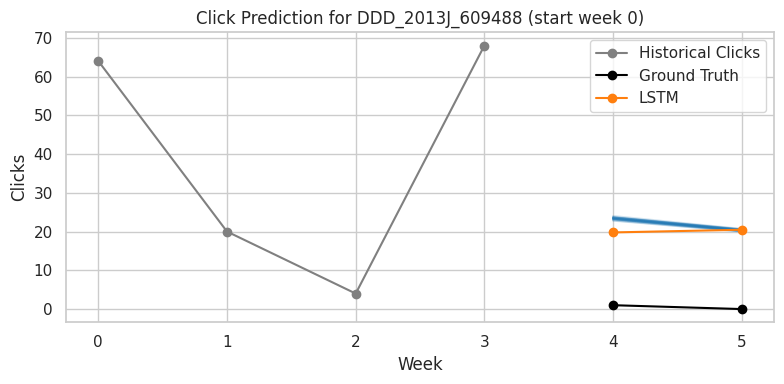

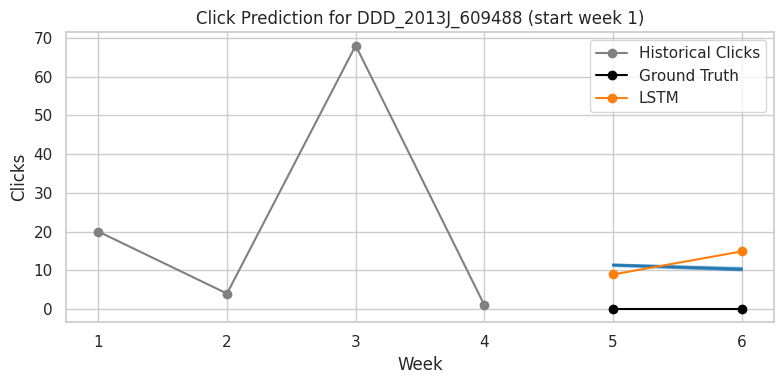

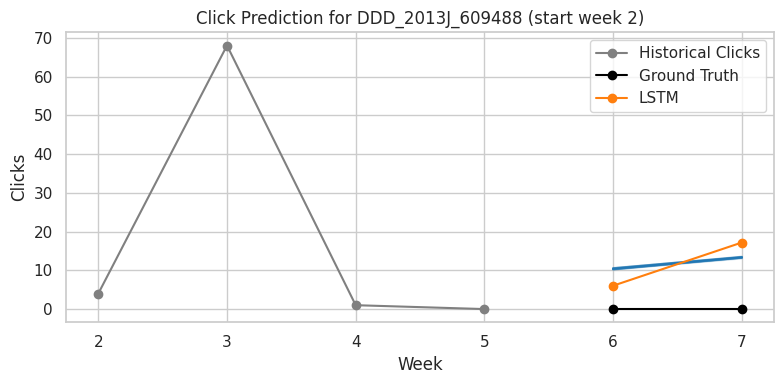

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set font to a Chinese font
# chinese_font = 'Noto Sans CJK SC'
# if chinese_font in [f.name for f in fm.fontManager.ttflist]:
#     plt.rcParams['font.sans-serif'] = [chinese_font]
#     plt.rcParams['axes.unicode_minus'] = False
#     print(f"Using font: {chinese_font}")
# else:
#     print(f"Warning: Font '{chinese_font}' not found. Chinese characters may not display correctly.")
#     print("Available fonts:")
#     for font in fm.fontManager.ttflist:
#         print(font.name)


def plot_sequence_example(
    dataset: SequenceDataset,
    idx: int,
    lstm_model: Seq2SeqLSTM,
    vae_model: Seq2SeqVAE,
    n_samples: int = 20
):
    seq = dataset.sequences[idx]
    normalized_inputs = dataset.normalize_features(seq['inputs']).astype(np.float32)
    inputs_tensor = torch.from_numpy(normalized_inputs).unsqueeze(0).to(DEVICE)
    initial_clicks = last_click_from_inputs(inputs_tensor)
    lstm_model.eval()
    vae_model.eval()
    with torch.no_grad():
        lstm_pred = lstm_model(inputs_tensor, initial_clicks, targets=None, teacher_forcing=0.0)
        vae_sampled = vae_model.sample(inputs_tensor, initial_clicks, n_samples=n_samples)
    lstm_pred = lstm_pred.cpu().numpy().flatten()
    vae_sampled = vae_sampled.cpu().numpy()
    history_clicks = seq['inputs'][:, CLICK_IDX]
    future_truth = seq['target']
    weeks_history = np.arange(seq['start_week'], seq['start_week'] + PAST_STEPS)
    weeks_future = np.arange(seq['start_week'] + PAST_STEPS, seq['start_week'] + PAST_STEPS + FUTURE_STEPS)

    plt.figure(figsize=(8, 4))
    # Changed labels and title to English
    plt.plot(weeks_history, history_clicks, '-o', color='gray', label='Historical Clicks')
    # Ensure vae_sampled has shape (n_samples, FUTURE_STEPS) for plotting
    if vae_sampled.ndim > 2:
        vae_sampled = vae_sampled.squeeze() # Remove extra dimensions

    for sample in vae_sampled:
        plt.plot(weeks_future, sample, color='tab:blue', alpha=0.2)
    plt.plot(weeks_future, future_truth, '-o', color='black', label='Ground Truth')
    plt.plot(weeks_future, lstm_pred, '-o', color='tab:orange', label='LSTM')
    plt.xlabel('Week')
    plt.ylabel('Clicks')
    plt.title(f"Click Prediction for {seq['student_key']} (start week {seq['start_week']})")
    plt.legend()
    plt.tight_layout()
    plt.show()

num_examples_to_plot = min(3, len(test_dataset))
for idx in range(num_examples_to_plot):
    plot_sequence_example(test_dataset, idx, lstm_model, vae_model, n_samples=20)

In [38]:
import numpy as np

# === 評估指標 ===
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def best_of_n_mse(y_true, y_preds_samples):
    # y_preds_samples: [n_samples, batch_size, seq_len]
    if y_preds_samples.size == 0:
        return float('nan')
    # Calculate MSE for each sample across all batches and time steps
    mse_per_sample = np.mean((y_preds_samples - y_true[np.newaxis, :, :]) ** 2, axis=(1, 2))
    return float(np.min(mse_per_sample))

def diversity(y_preds_samples):
    # y_preds_samples: [n_samples, batch_size, seq_len]
    if y_preds_samples.size == 0:
        return float('nan')
    # Calculate std deviation across samples for each element in the sequence
    std_across_samples = np.std(y_preds_samples, axis=0)
    # Mean of the standard deviations across all batch items and time steps
    return float(np.mean(std_across_samples))

def coverage(y_true, y_preds_samples):
    # y_true: [batch_size, seq_len]
    # y_preds_samples: [n_samples, batch_size, seq_len]
    if y_preds_samples.size == 0:
         return float('nan')
    min_pred = np.min(y_preds_samples, axis=0)
    max_pred = np.max(y_preds_samples, axis=0)
    within = (y_true >= min_pred) & (y_true <= max_pred)
    return float(np.mean(within))


# Use the results from the previous cell
y_true = test_targets
y_pred_lstm = lstm_preds
y_pred_vae = vae_samples # This is already in the shape [n_samples, batch_size, seq_len]


# === 計算 ===
mse_lstm = mse(y_true, y_pred_lstm)
best_of_n_vae = best_of_n_mse(y_true, y_pred_vae)
div_vae = diversity(y_pred_vae)
# Note: Coverage calculation does not need a tolerance parameter based on the definition
cov_vae = coverage(y_true, y_pred_vae)

print(f"LSTM MSE: {mse_lstm:.4f}")
print(f"VAE Best-of-N MSE: {best_of_n_vae:.4f}")
print(f"VAE Diversity: {div_vae:.4f}")
print(f"VAE Coverage: {cov_vae:.4f}")

LSTM MSE: 1782.3273
VAE Best-of-N MSE: 1793.8765
VAE Diversity: 0.1999
VAE Coverage: 0.5257
